In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import spectrogram

## CHANGE IF EXPORT NEEDED:

In [2]:
EXPORT = False # whether to export data and images

### 0. Define Plot Functions

In [3]:
def plot_fft_cycle_and_power(pair, EXPORT = False):
    fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
    
    # Plot cycle length
    axs[0].plot(dominant_cycles[pair], label='Cycle Length (days)')
    axs[0].set_ylabel('Cycle Length')
    axs[0].set_title(f'{pair} – Dominant Cycle Length and Power')
    axs[0].grid(True)
    
    # Plot power
    axs[1].plot(powers[pair], label='Cycle Power', color='orange')
    axs[1].set_ylabel('Power')
    axs[1].set_xlabel('Date')
    axs[1].grid(True)
    
    plt.tight_layout()
    
    if EXPORT:
        plt.savefig(f"fx_{pair}_fft_cycle_and_power_chart.png") # save chart
        
    plt.show()

def plot_fft_cycle_and_power_grid(fft_dict, label, EXPORT = False):
    n = len(pairs)
    ncols = 2
    nrows = (n + 1) // ncols
    
    fig, axs = plt.subplots(nrows, ncols, figsize=(12, 2.5 * nrows))
    axs = axs.flatten()
    
    for i, pair in enumerate(pairs):
        axs[i].plot(fft_dict[pair])
        axs[i].set_title(pair)
        axs[i].set_ylabel("Cycle Length")
        axs[i].grid(True)
    
    # Hide unused axes
    for j in range(i + 1, len(axs)):
        axs[j].set_visible(False)

    plt.suptitle(f"Dominant Cycle {label} (FFT, {window}d Rolling) Across Major FX Pairs", fontsize=14, y=1.02)
    
    plt.tight_layout()

    if EXPORT:
        plt.savefig(f"fx_fft_cycle_{label}_grid.png") # save chart

    plt.show()

def plot_fft_cycle_and_power_scatter(EXPORT = False):

    fig, ax = plt.subplots(figsize=(8, 6))
    
    for pair in pairs:
        ax.scatter(
            dominant_cycles[pair].values,
            powers[pair].values,
            label=pair,
            alpha=0.4,
            s=10  # point size
        )
    
    ax.set_xlabel("Cycle Length (days)")
    ax.set_ylabel("Cycle Power")
    ax.set_title("Power vs. Cycle Length Across FX Pairs")
    ax.legend()
    ax.grid(True)
    plt.tight_layout()

    if EXPORT:
        plt.savefig(f"fx_fft_cycle_and_power_scatter.png") # save chart
        
    plt.show()

### 1. Define path, pairs, FFT window

In [4]:
data_dir = Path("data/")
pairs = ['EURUSD', 'USDJPY', 'GBPUSD', 'USDCHF', 'AUDUSD', 'USDCAD', 'NZDUSD']
window = 256 # power of 2 + roughly 1 trading year

EXPORT = False

### 2. Load Data

In [5]:
raw_data = {}

for pair in pairs:
    df = pd.read_csv(data_dir / f"{pair}.csv", parse_dates = ['Date'])
    df = df.set_index("Date").sort_index()
    df = df.asfreq("B")
    df['Close'] = df['Price'].ffill()
    raw_data[pair] = df

### 3. Compute Log Returns

In [6]:
log_returns = {}

for pair, df in raw_data.items():
    df['log_price'] = np.log(df['Close'])
    df['log_return'] = df['log_price'].diff()
    log_returns[pair] = df['log_return'].dropna()

### 4. Loop over pairs and apply rolling FFT

In [7]:
dominant_cycles = {}
powers = {}

for pair, series in log_returns.items():
    y = series.values
    T = len(y)
    cycles = []
    power_vals = []

    # for t in range(0, 1):
    for t in range(0, T - window + 1):
        segment = y[t:t+window]
        fft_vals = np.fft.fft(segment)
        mag = np.abs(fft_vals[:window // 2])  # magnitude of positive freqs
        
        # Ignore DC (bin 0)
        dominant_idx = np.argmax(mag[1:]) + 1 # ignore 0 frequency magnitude
        cycle_len = window / dominant_idx # compute cycle length as window / id 
        cycle_power = mag[dominant_idx]**2 # compute power = magnitude ** 2

        cycles.append(cycle_len) 
        power_vals.append(cycle_power)

    # assign to last date of series used to compute = date info becomes available
    dominant_cycles[pair] = pd.Series(cycles, index=series.index[window - 1:])  # e.g., first uses 0...255 assign to 255
    powers[pair] = pd.Series(power_vals, index=series.index[window - 1:]) # e.g., first uses 0...255 assign to 255

### 5. Combine across pairs

In [8]:
output_rows = []

for pair in pairs:
    dates = dominant_cycles[pair].index
    lengths = dominant_cycles[pair].values
    powers_ = powers[pair].values

    for date, cl, pw in zip(dates, lengths, powers_):
        output_rows.append({
            'date': date,
            'pair': pair,
            'cycle_length': cl,
            'cycle_power': pw
        })

df_out = pd.DataFrame(output_rows)

if EXPORT:
    df_out.to_csv("fft_cycle_tags.csv", index=False)

### 6. Plot Dominant Cycle Grid across pairs

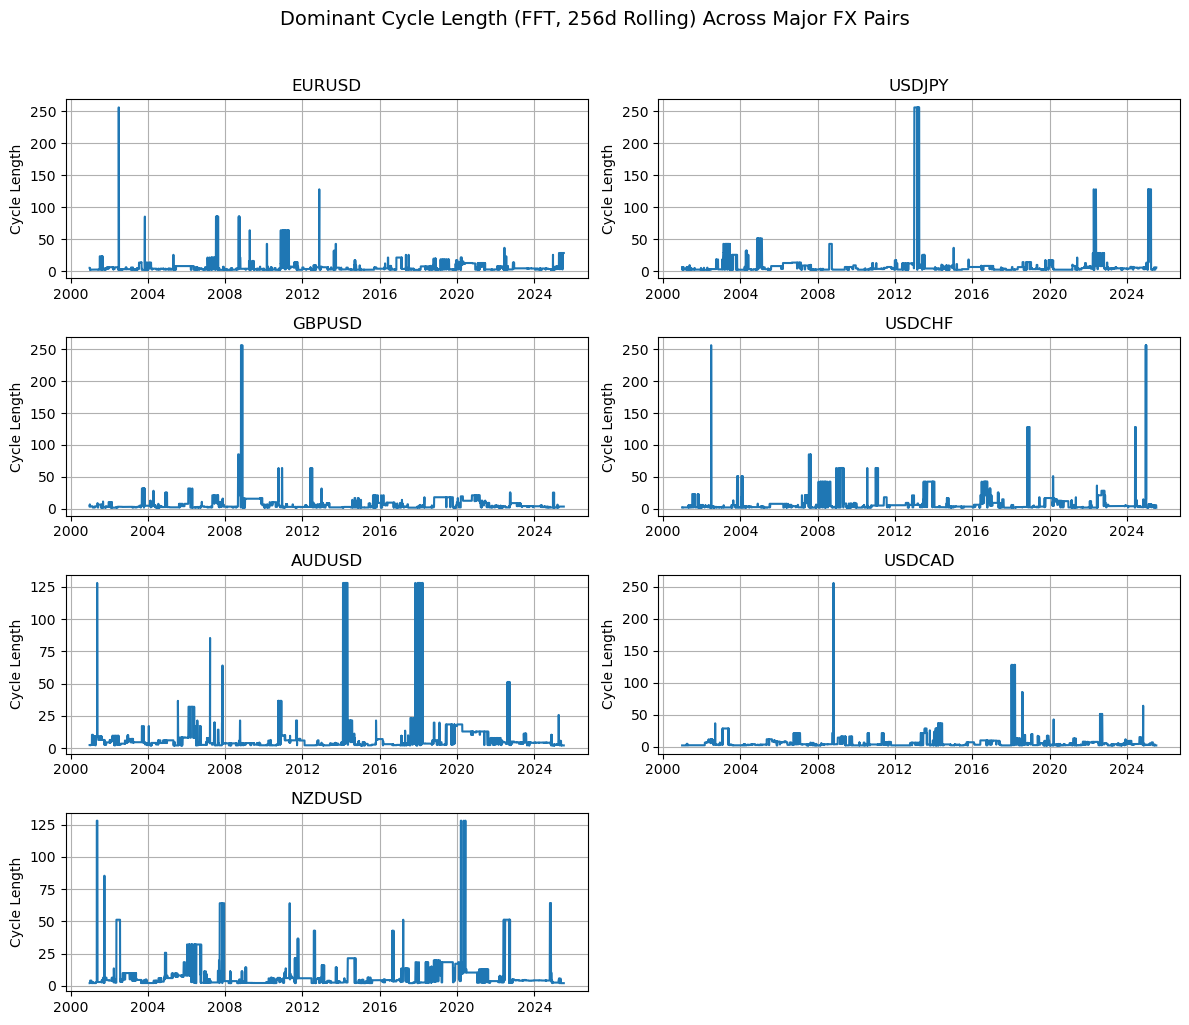

In [9]:
plot_fft_cycle_and_power_grid(dominant_cycles, "Length")

### 7. Plot Power across all pairs

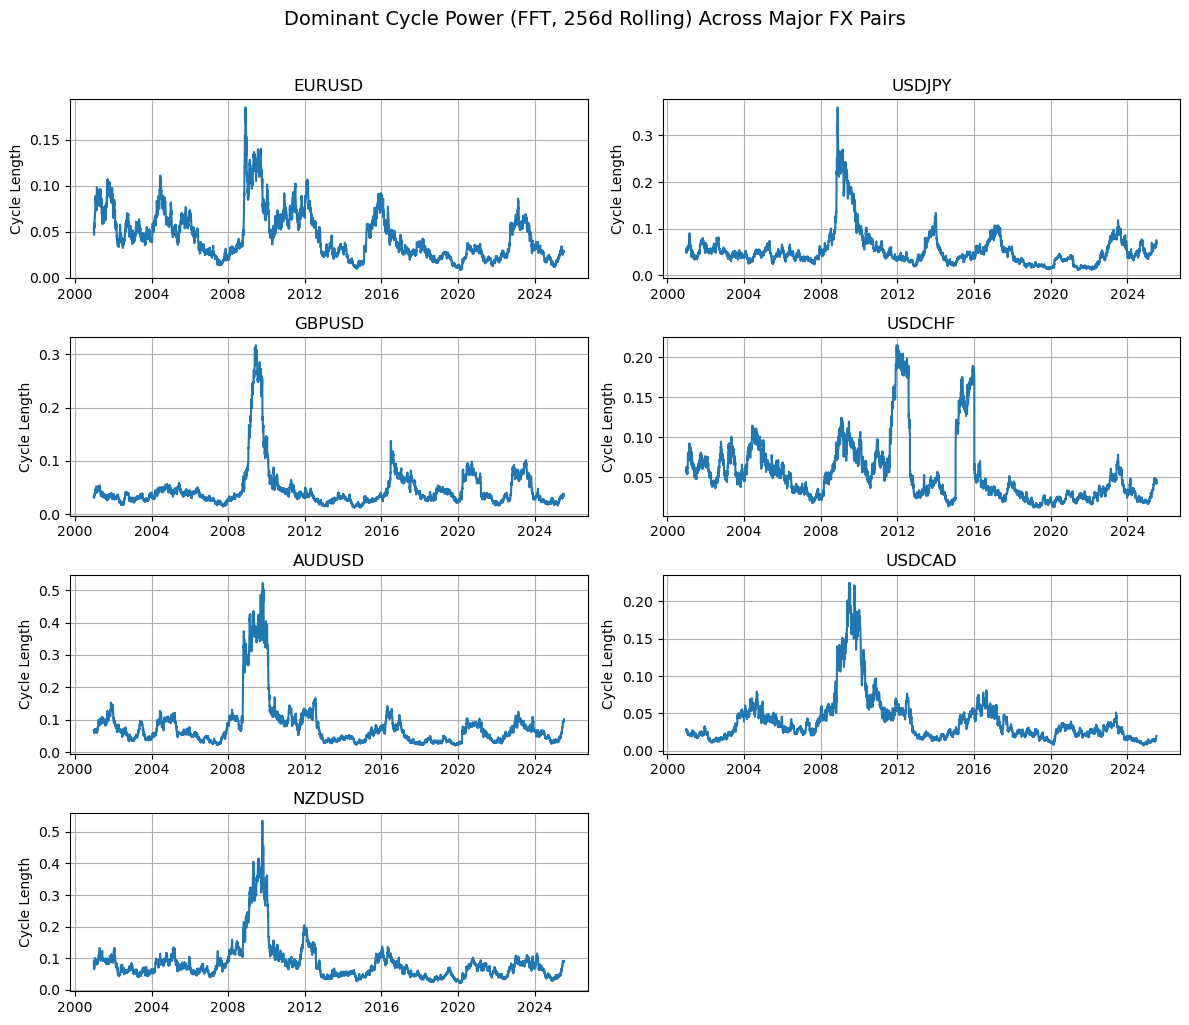

In [10]:
plot_fft_cycle_and_power_grid(powers, "Power")

### 8. Scatter Plot – Cycle Length vs. Power

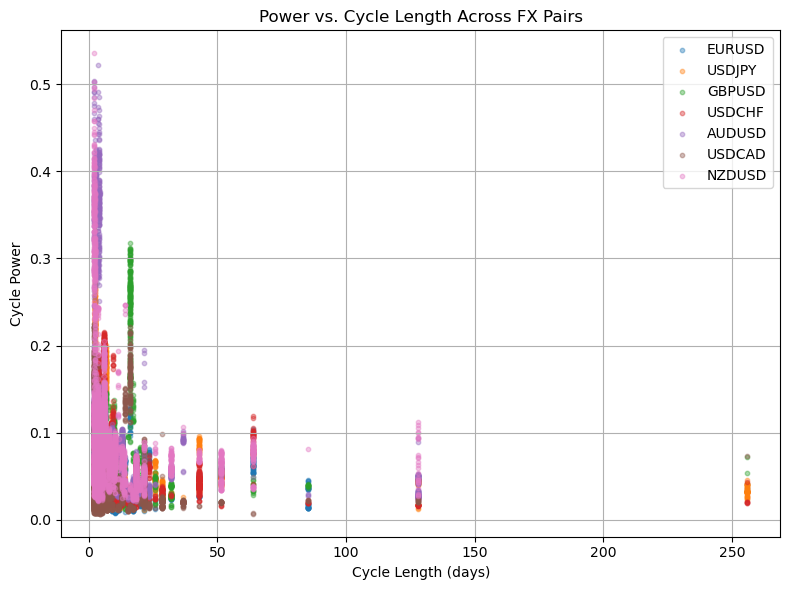

In [11]:
plot_fft_cycle_and_power_scatter()